# Modelling (in work)

#### Research Questions:
- What factors have the most significant impact on movie revenue?
- Can we predict movie revenue accurately using pre-release features (budget, cast, director)?
- How do audience and critic reviews influence box office success?


## 0.setup

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import scipy.stats as stats


notebook_dir = Path().resolve()
project_root  = notebook_dir.parent
data_path     = project_root / "data_collection" / "omdb_cleaned.csv"

df = pd.read_csv(data_path)

## 1. What factors have the most significant impact on movie revenue?

In this section we filtered out non-4-digit years to remove series because they last for several years (e.g. 2012-2016)

We also pasrsed `Runtime` and then added `log_budget` and `log_imdbVotes` alongside `imdbRating`, `Runtime` and `Year` to our feature set and computed their Pearson correlations with **log_BoxOffice**. 

We use log1p on `revenue`, `budget`, and votes to tame extreme outliers, stabilize variance, and linearize these power‐law relationships so our correlation (and subsequent regression) estimates are more reliable.


In [28]:
#removing tv-series from the dataset
#because they have interval years like 2010-2015
mask_bad_year = ~df['Year'].astype(str).str.match(r'^\d{4}$', na=False)
df = df.loc[~mask_bad_year].copy()
df['Year'] = df['Year'].astype(int)

df['Runtime'] = pd.to_numeric(
    df['Runtime'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)

# ensure budget is numeric and log-transform skewed numerics
df = df[df['budget'] > 0].copy()
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['log_budget'] = np.log1p(df['budget'])
df['log_imdbVotes'] = np.log1p(df['imdbVotes'])
df['log_BoxOffice'] = np.log1p(df['BoxOffice'])

numeric_feats = ['Year', 'Runtime', 'imdbRating', 'log_imdbVotes', 'log_budget']
target = 'log_BoxOffice'
model_df = df[numeric_feats + [target]].dropna()

corrs = model_df.corr()[target].drop(target).sort_values(ascending=False)
print(corrs)

log_imdbVotes    0.701439
log_budget       0.492259
Runtime          0.220109
imdbRating       0.186830
Year            -0.047588
Name: log_BoxOffice, dtype: float64


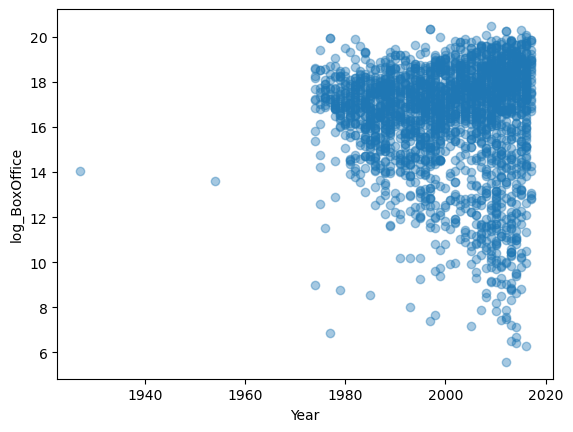

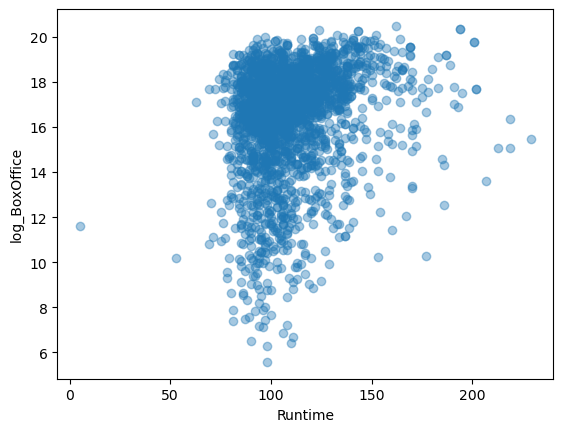

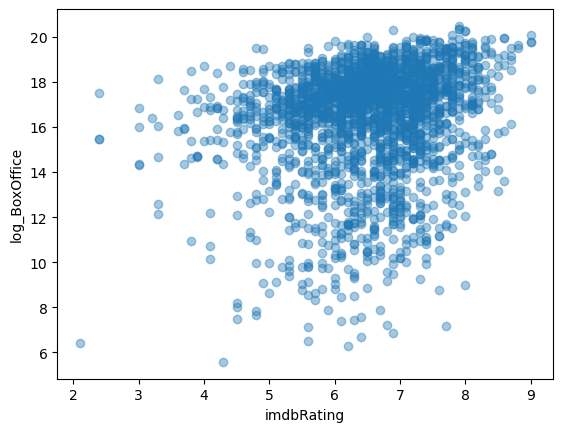

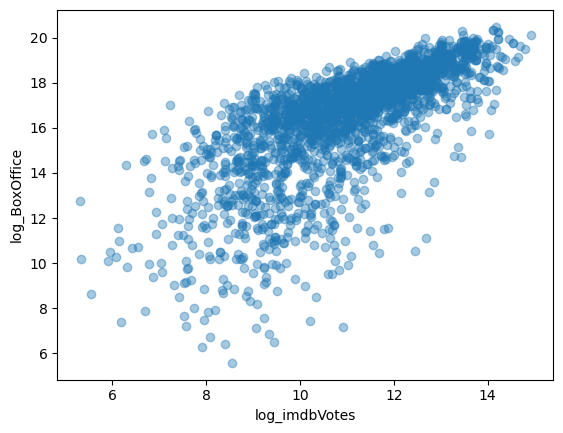

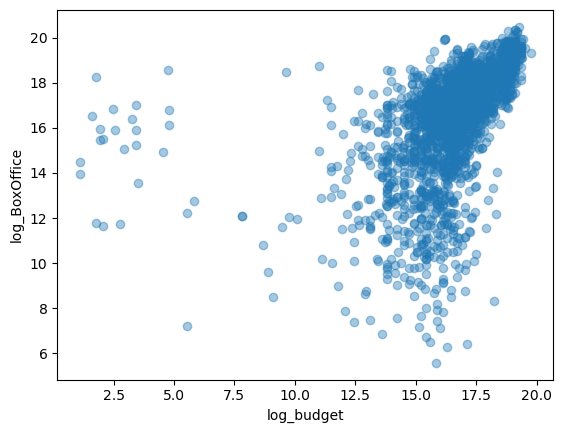

In [29]:
for feat in numeric_feats:
    plt.figure()
    plt.scatter(model_df[feat], model_df[target], alpha=0.4)
    plt.xlabel(feat)
    plt.ylabel(target)
    plt.show()

- `log_imdbVotes` vs `log_BoxOffice`
A very concentrated and almost linear upward with more IMDb votes almost always earn disproportionately higher box-office. This is our single strongest driver.

- `log_budget` vs `log_BoxOffice`
A clear positive trend: bigger production budgets generally translate into higher revenues

- `imdbRating` vs `log_BoxOffice`
Almost no patterns

- `Runtime ` vs `log_BoxOffice`
A slight upward slope—longer films earn a bit more but only with a minor effect

In [30]:
project_root = Path().resolve().parent
df = pd.read_csv(project_root / "data_collection" / "omdb_cleaned.csv")

mask = ~df['Year'].astype(str).str.match(r'^\d{4}$', na=False)
df = df.loc[~mask].copy()
df['Year'] = df['Year'].astype(int)
df['Runtime'] = pd.to_numeric(
    df['Runtime'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)

df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df = df[df['budget'] > 0].copy()
df['log_budget'] = np.log1p(df['budget'])

df['log_BoxOffice']   = np.log1p(df['BoxOffice'])
df['log_imdbVotes']   = np.log1p(df['imdbVotes'])

#top 10 genres
genres = df['Genre'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
mlb    = MultiLabelBinarizer()
ohe    = pd.DataFrame(mlb.fit_transform(genres),
                      columns=mlb.classes_,
                      index=df.index)
top10  = ohe.sum().nlargest(10).index
df[top10] = ohe[top10]

feature_cols = ['log_imdbVotes', 'imdbRating', 'Runtime', 'Year', 'log_budget'] + top10.tolist()
X = df[feature_cols]
y = df['log_BoxOffice']
mask2 = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask2], y.loc[mask2]

# ols regression
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
pipeline.fit(X, y)

#coeffs + r^2
coefs = pipeline.named_steps['linearregression'].coef_
coef_series = pd.Series(coefs, index=X.columns).sort_values(key=abs, ascending=False)
print("Standardized coefficients:\n", coef_series)
print("\nR²:", pipeline.score(X, y))

Standardized coefficients:
 log_imdbVotes                   1.807869
Year                           -0.619258
imdbRating                     -0.533482
log_budget                      0.454227
Animation, Adventure, Comedy    0.243771
Comedy, Drama, Romance          0.121418
Runtime                         0.116596
Comedy, Romance                 0.106494
Comedy                          0.051611
Action, Adventure, Comedy       0.017770
Comedy, Drama                   0.017695
Drama                          -0.016632
Action, Adventure, Sci-Fi       0.013041
Drama, Romance                  0.006048
Action, Crime, Drama           -0.002422
dtype: float64

R²: 0.6090793195731649


## Insights from the Linear Regression

**Overall Fit** R²0.61. These independent variables explain 61% of the variance in log-BoxOffice.

`log_imdbVotes` has the largest standardized coefficient (1.807) confirming that audience engagement is the strongest driver of revenue

Budget matters too: `log_budget` comes in as the second most important positive predictor (0.454), indicating that bigger production spends translate into higher box-office, but with the  less intensity than votes.

`imdbRating` ≈ –0.53 and `Year` ≈ –0.62



## Model Diagnostics

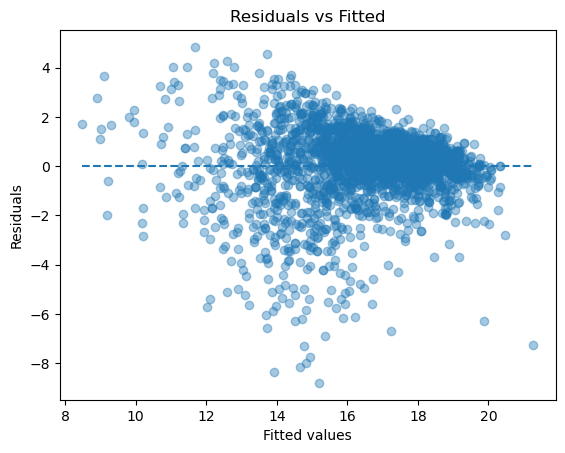

In [34]:
y_pred = pipeline.predict(X)
residuals = y - y_pred

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.4)
plt.hlines(0, y_pred.min(), y_pred.max(), linestyles='dashed')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()


The points on the scatter plot are spreaded evenly above and below zero which is good. It indicates that we are not missing any non-linear trend.

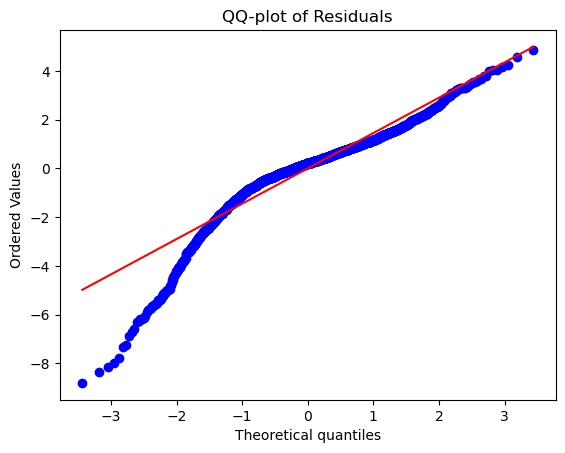

In [ ]:
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

- Most of the residuals lie close to the 45 degrees line, meaning that the errors are approximately *normally distributed* in the center.

- Nevertheless, it can be noticed that the on left tail the dots bend away, indicating a few outliers where the model over- or under-predicts log-revenue more than a perfect normal would. 

In [36]:
# Variance Inflation Factors
vif_data = pd.DataFrame({'feature': X.columns})
vifs = []
for col in X.columns:
    X_other = X.drop(columns=col)
    r2 = LinearRegression().fit(X_other, X[col]).score(X_other, X[col])
    vifs.append(1.0 / (1.0 - r2))
vif_data['VIF'] = vifs
print(vif_data)

                         feature       VIF
0                  log_imdbVotes  2.016909
1                     imdbRating  1.695037
2                        Runtime  1.327522
3                           Year  1.123234
4                     log_budget  1.529860
5         Comedy, Drama, Romance  1.037912
6                         Comedy  1.025694
7           Action, Crime, Drama  1.014893
8                          Drama  1.047398
9      Action, Adventure, Sci-Fi  1.078098
10                 Comedy, Drama  1.032886
11  Animation, Adventure, Comedy  1.107801
12                Drama, Romance  1.028959
13               Comedy, Romance  1.017315
14     Action, Adventure, Comedy  1.025042


All VIFs are well below 5 (and most are ≈1–2), which tells us our predictors aren’t highly correlated with each other.

## 

# make dummies for genres

example
film has drama = 0 or drama = 1 


1     Model diagnostics

Residual plots (residual vs. fitted) and QQ-plots to check linear-model assumptions.

Variance Inflation Factors (VIF) for multicollinearity among predictors.

2      Incremental (block) regression

Fit nested models (e.g.

log_votes only → R²₁

rating/runtime/year → R²₂

genres → R²₃
) so you can quantify how much each “family” of predictors adds to explained variance (∆R²).

3       Additional pre-release features

Merge in budget (log-transformed), award counts, director track record, distributor size, etc.

Refit to see how much R² improves and whether new β’s are significant.

4      Visualization for slides

Bar chart of standardized β’s.

A small table summarizing “top 3 positive” and “top 2 negative” drivers.

A plot of R² gains from each block of predictors.

5      Robustness check (optional)

A Random Forest with permutation importance or SHAP to confirm that the same features matter even in a non-parametric model.